# Data Visualization and Preprocessing

### Import Libraries

In [3]:
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap as sh
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn import preprocessing

### Load High Popularity Songs Dataset

In [5]:
high_df = pd.read_csv("../data/high_popularity_spotify_data.csv")
high_df.head()


,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3,0.0304,...,0.0000,10FLjwfpbxLmW8c25Xyc2N,0,6,251668,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4,0.0358,...,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1,2,210373,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4,0.0368,...,0.0000,0hBRqPYPXhr1RkTDG3n4Mk,1,1,166300,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4,0.0634,...,0.0000,4B4Elma4nNDUyl6D5PvQkj,0,0,157280,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4,0.2600,...,0.0000,2IYQwwgxgOIn7t3iF6ufFD,0,0,169917,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


### Load Low Popularity Songs Dataset

In [7]:
low_df = pd.read_csv("../data/low_popularity_spotify_data.csv")
low_df.head()


,time_signature,track_popularity,speechiness,danceability,playlist_name,track_artist,duration_ms,energy,playlist_genre,playlist_subgenre,...,track_album_id,playlist_id,track_id,valence,key,tempo,loudness,acousticness,liveness,track_album_name
0,4.0,23,0.0393,0.636,Rock Classics,Creedence Clearwater Revival,138053.0,0.746,rock,classic,...,4A8gFwqd9jTtnsNwUu3OQx,37i9dQZF1DWXRqgorJj26U,5e6x5YRnMJIKvYpZxLqdpH,0.432,0.0,132.310,-3.785,0.0648,0.1730,The Long Road Home - The Ultimate John Fogerty...
1,4.0,53,0.0317,0.572,Rock Classics,Van Halen,241600.0,0.835,rock,classic,...,2c965LEDRNrXXCeBOAAwns,37i9dQZF1DWXRqgorJj26U,5FqYA8KfiwsQvyBI4IamnY,0.795,0.0,129.981,-6.219,0.1710,0.0702,The Collection
2,4.0,55,0.0454,0.591,Rock Classics,Stevie Nicks,329413.0,0.804,rock,classic,...,3S404OgKoVQSJ3xXrDVlp8,37i9dQZF1DWXRqgorJj26U,5LNiqEqpDc8TuqPy79kDBu,0.658,0.0,111.457,-7.299,0.3270,0.0818,Bella Donna (Deluxe Edition)
3,4.0,64,0.1010,0.443,Jazz Classics,"Ella Fitzgerald, Louis Armstrong",185160.0,0.104,jazz,classic,...,1y5KGkUKO0NG32MhIIagCA,37i9dQZF1DXbITWG1ZJKYt,78MI7mu1LV1k4IA2HzKmHe,0.394,0.0,76.474,-17.042,0.9130,0.1910,"Love, Ella"
4,4.0,62,0.0298,0.685,Jazz Classics,Galt MacDermot,205720.0,0.472,jazz,classic,...,6f4b9wVTkKAf096k4XG6x5,37i9dQZF1DXbITWG1ZJKYt,6MN6yRVriszuyAVlyF8ndB,0.475,9.0,80.487,-9.691,0.7850,0.2240,Shapes of Rhythm/Woman Is Sweeter


### Identify Numerical and Categorical Features

In [9]:
# Numerical features
numerical_features = high_df.select_dtypes(include=['number']).columns.tolist()

# Categorical features
categorical_features = high_df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Features: ", numerical_features)
print("\nCategorical Features High: ", categorical_features)

Numerical Features:  ['energy', 'tempo', 'danceability', 'loudness', 'liveness', 'valence', 'time_signature', 'speechiness', 'track_popularity', 'instrumentalness', 'mode', 'key', 'duration_ms', 'acousticness']

Categorical Features High:  ['playlist_genre', 'track_artist', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']


### Check For Null Values

In [11]:
def check_nulls(df, name="DataFrame"):
    if df.isnull().sum().sum() == 0:
        print(f"No null values found in {name}.")
    else:
        print(f"\nEntries with null values in {name}:")
        print(df[df.isnull().any(axis=1)])

check_nulls(high_df, "high_df")
check_nulls(low_df, "low_df")

No null values found in high_df.

Entries with null values in low_df:
     time_signature  track_popularity  speechiness  danceability  \
263             NaN                50          NaN           NaN   

              playlist_name track_artist  duration_ms  energy playlist_genre  \
263  Chill Lofi Study Beats     Berhanio          NaN     NaN           lofi   

    playlist_subgenre  ...          track_album_id             playlist_id  \
263             chill  ...  4X9vWjNWlZ3qAtyDZ2ZhDj  37i9dQZF1DX8Uebhn9wzrS   

                   track_id valence key tempo loudness acousticness  liveness  \
263  2teI76KKFE6qkpLZJs7tZ7     NaN NaN   NaN      NaN          NaN       NaN   

    track_album_name  
263          Make It  

[1 rows x 29 columns]


### Handle Missing Values
In this case, there is only one null value, so the most appropriate solution is to simply remove it.

In [13]:
low_df.drop(index=263, inplace=True)
low_df.loc[260:265]

,time_signature,track_popularity,speechiness,danceability,playlist_name,track_artist,duration_ms,energy,playlist_genre,playlist_subgenre,...,track_album_id,playlist_id,track_id,valence,key,tempo,loudness,acousticness,liveness,track_album_name
260,4.0,51,0.1190,0.666,Chill Lofi Study Beats,Audio Phill,122984.0,0.2530,lofi,chill,...,4mEfZGlxMcC0EioQfzvnyx,37i9dQZF1DX8Uebhn9wzrS,4lZQn9ZVkTbzehDoj3SQin,0.181,0.0,129.971,-16.196,0.906,0.1220,The City
261,4.0,51,0.2440,0.804,Chill Lofi Study Beats,M.I Hakone,124337.0,0.3510,lofi,chill,...,1Gi40W4rRup1t8B0p5Y5Yf,37i9dQZF1DX8Uebhn9wzrS,6RUXqsK0MlNGXFWBfZs400,0.740,8.0,76.992,-10.686,0.887,0.1070,Seasons
262,4.0,51,0.0777,0.879,Chill Lofi Study Beats,Zoe Reed,148583.0,0.2180,lofi,chill,...,4KtXivGbPCcyyzs8mb54CJ,37i9dQZF1DX8Uebhn9wzrS,3oY2RXnYoPhtf6r552KfbN,0.663,3.0,129.997,-16.681,0.566,0.1030,the clearing
264,4.0,51,0.0390,0.643,Chill Lofi Study Beats,Convivial,187023.0,0.0408,lofi,chill,...,100YLSEn3RzaqIyNKQzEk3,37i9dQZF1DX8Uebhn9wzrS,6CVpyt67DY1JwuR8prqPmP,0.152,5.0,130.014,-17.989,0.825,0.0959,Softly Whispering
265,4.0,50,0.0542,0.670,Chill Lofi Study Beats,"Yawuh, Koralle",143145.0,0.3790,lofi,chill,...,2BqsfiOuHmaRdp10PIpT5q,37i9dQZF1DX8Uebhn9wzrS,7M9vscwYkaJkTInBY2y6jv,0.552,10.0,147.970,-11.249,0.596,0.2400,Matcha


### Combine and Measure Data

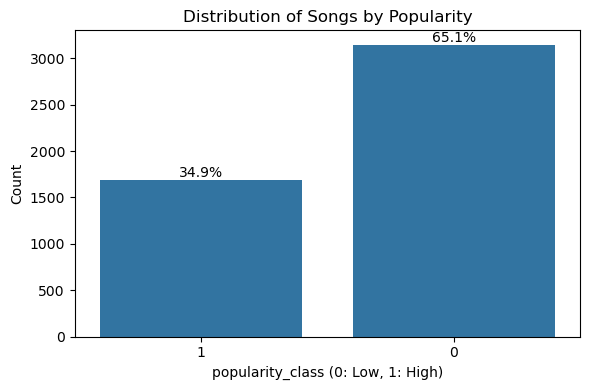

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,playlist_name,track_album_release_date,instrumentalness,mode,key,duration_ms,acousticness,playlist_subgenre,popularity_class
0,0.592,157.969,0.521,pop,-7.777,0.1220,0.535,"Lady Gaga, Bruno Mars",3.0,0.0304,Today's Top Hits,2024-08-16,0.0000,0.0,6.0,251668.0,0.3080,mainstream,1
1,0.507,104.978,0.747,pop,-10.171,0.1170,0.438,Billie Eilish,4.0,0.0358,Today's Top Hits,2024-05-17,0.0608,1.0,2.0,210373.0,0.2000,mainstream,1
2,0.808,108.548,0.554,pop,-4.169,0.1590,0.372,Gracie Abrams,4.0,0.0368,Today's Top Hits,2024-10-18,0.0000,1.0,1.0,166300.0,0.2140,mainstream,1
3,0.910,112.966,0.670,pop,-4.070,0.3040,0.786,Sabrina Carpenter,4.0,0.0634,Today's Top Hits,2024-08-23,0.0000,0.0,0.0,157280.0,0.0939,mainstream,1
4,0.783,149.027,0.777,pop,-4.477,0.3550,0.939,"ROSÉ, Bruno Mars",4.0,0.2600,Today's Top Hits,2024-10-18,0.0000,0.0,0.0,169917.0,0.0283,mainstream,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4824,0.424,75.466,0.352,indian,-8.009,0.2420,0.605,M. S. Subbulakshmi,1.0,0.0634,Carnatic Classics,2013-01-18,0.0000,1.0,10.0,661293.0,0.9650,classical,0
4825,0.349,147.193,0.471,indian,-16.633,0.2860,0.358,Jayanthi Kumaresh,4.0,0.0656,Carnatic Classics,2002-12-01,0.9450,1.0,8.0,394400.0,0.9750,classical,0
4826,0.595,174.308,0.436,indian,-11.494,0.0939,0.870,"Nirmala Rajasekar, Raghavendra Rao, Tanjore K....",4.0,0.0671,Carnatic Classics,2010-10-26,0.8680,1.0,3.0,473440.0,0.8160,classical,0
4827,0.591,174.760,0.489,indian,-10.843,0.0770,0.689,Ganesh & Kumaresh,1.0,0.0813,Carnatic Classics,2007-01-01,0.9270,0.0,8.0,298987.0,0.9480,classical,0


In [15]:
# Add a new column to distinguish datasets
high_df['popularity_class'] = '1' # High
low_df['popularity_class'] = '0' # Low

target = 'popularity_class'

# Concatenate the two DataFrames
combined_df = pd.concat([high_df, low_df], ignore_index=True)

# Drop unneeded features
combined_df = combined_df.drop(columns = [
    "track_popularity",
    "track_album_name",
    "track_id",
    "track_name",
    "track_album_id",
    "playlist_id",
    "track_href",
    "uri",
    "analysis_url",
    "id",
    "type"
])

# Plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='popularity_class', data=combined_df)
plt.title('Distribution of Songs by Popularity')
plt.xlabel(target + ' (0: Low, 1: High)')
plt.ylabel('Count')

# Add percentage labels for each bar (relative to total dataset size)
total = len(combined_df)

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height == 0:
            continue
        percentage = '{:.1f}%'.format(100 * height / total)
        ax.annotate(percentage,
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', size=10)

plt.tight_layout()
plt.show()
combined_df

### Check For Duplicate Values

In [17]:
print(high_df.duplicated().sum())
print(low_df.duplicated().sum())

0
0


### Explore Feature Correlation

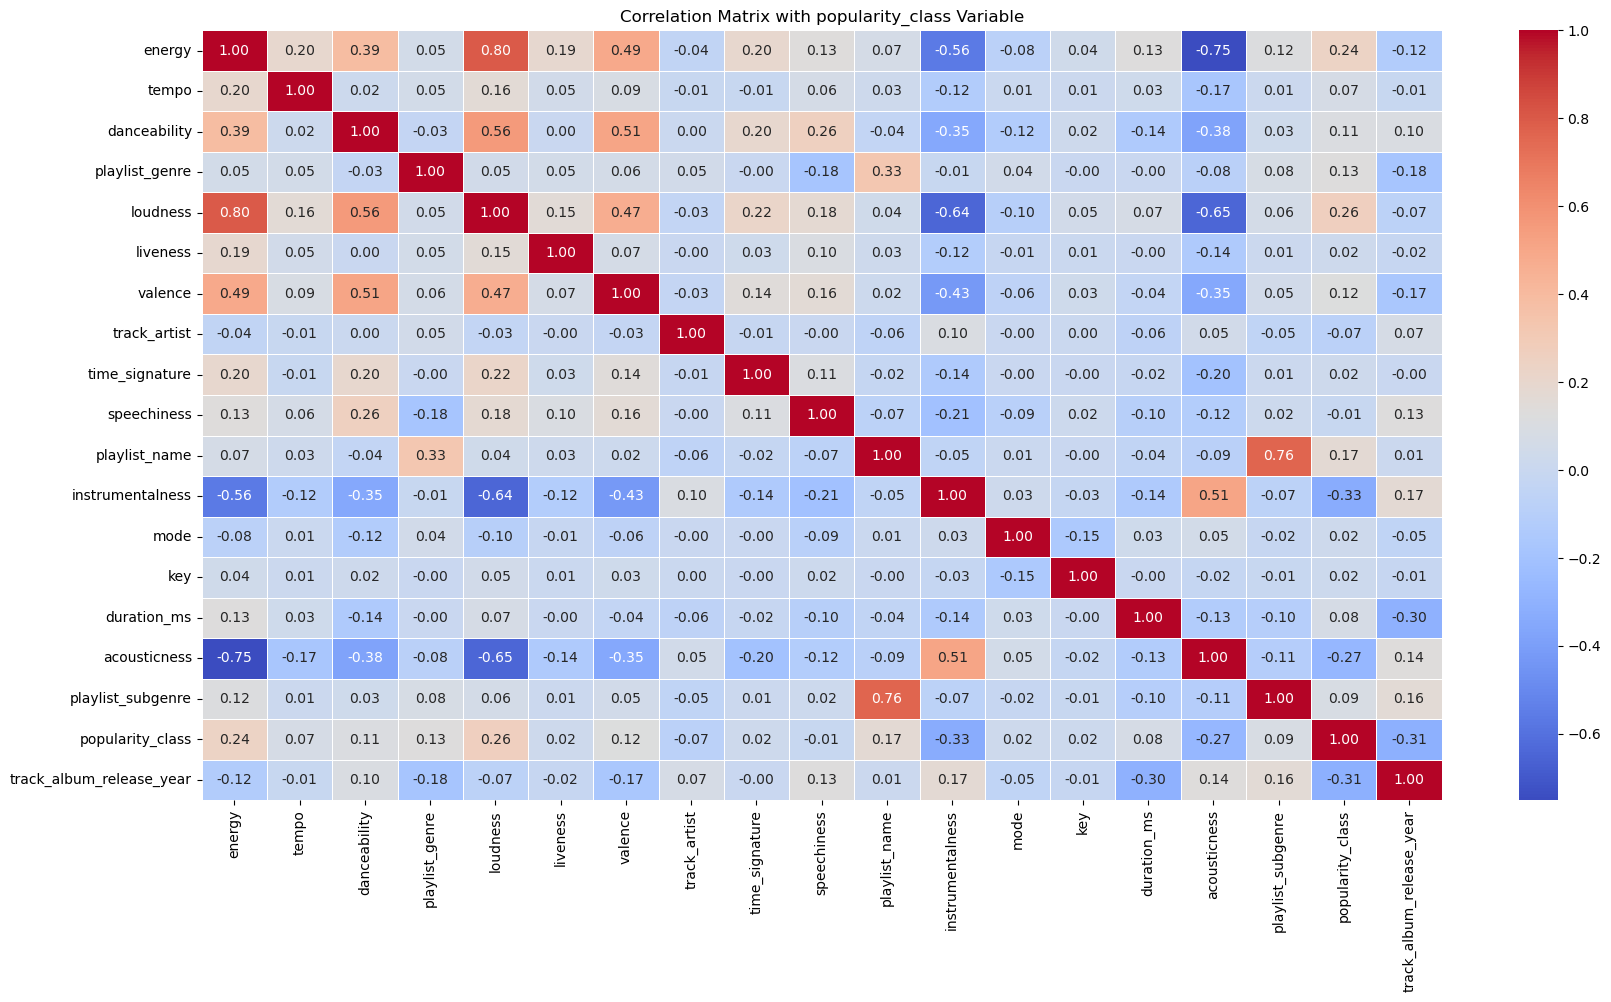


Correlation with Target Variable (popularity_class):
loudness                    0.264583
energy                      0.239181
playlist_name               0.165791
playlist_genre              0.129243
valence                     0.123973
danceability                0.109379
playlist_subgenre           0.090146
duration_ms                 0.075525
tempo                       0.072100
mode                        0.024210
time_signature              0.024150
liveness                    0.023293
key                         0.021604
speechiness                -0.005773
track_artist               -0.073905
acousticness               -0.269906
track_album_release_year   -0.306413
instrumentalness           -0.331914
Name: popularity_class, dtype: float64


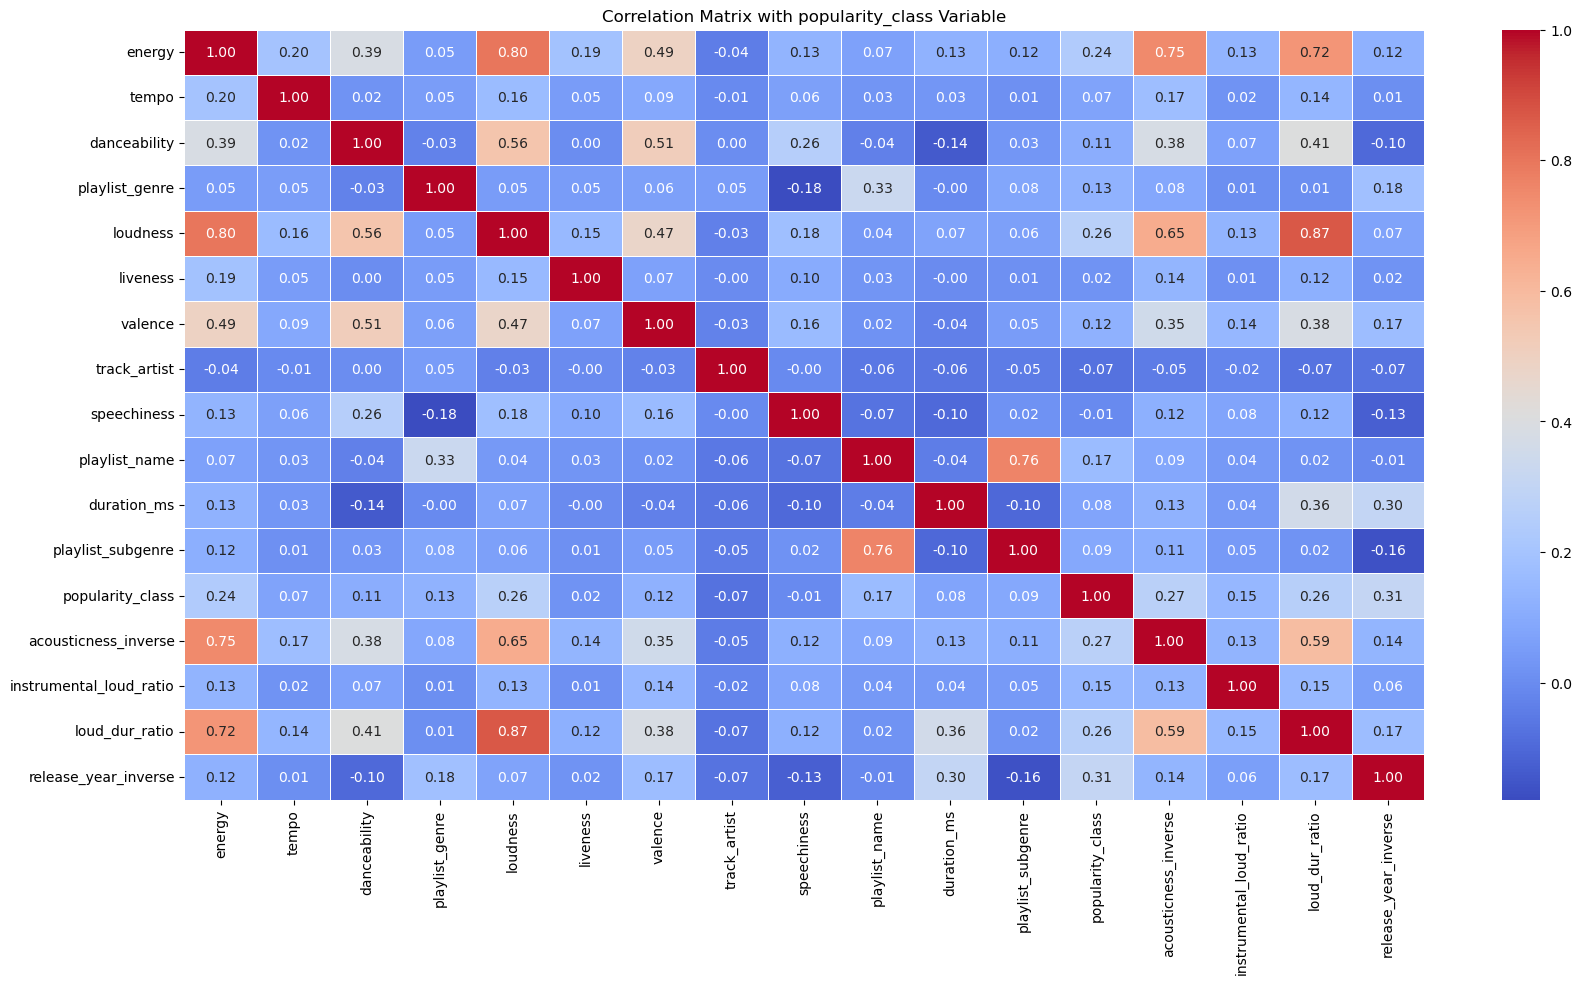


Correlation with Target Variable (popularity_class):
release_year_inverse       0.306506
acousticness_inverse       0.269906
loudness                   0.264583
loud_dur_ratio             0.260516
energy                     0.239181
playlist_name              0.165791
instrumental_loud_ratio    0.145682
playlist_genre             0.129243
valence                    0.123973
danceability               0.109379
playlist_subgenre          0.090146
duration_ms                0.075525
tempo                      0.072100
liveness                   0.023293
speechiness               -0.005773
track_artist              -0.073905
Name: popularity_class, dtype: float64


In [19]:
from sklearn.preprocessing import LabelEncoder
import joblib

# List of categorical features to encode
categorical_features = ['playlist_genre', 'playlist_subgenre', 'track_artist', 'playlist_name']

label_encoders = {}

# Fit and save encoders for each categorical feature
for feature in categorical_features:
    le = LabelEncoder()
    
    # Fit the encoder on all categories from your combined dataframe
    le.fit(combined_df[feature])  
    
    # Encode the feature in the dataframe
    combined_df[feature] = le.transform(combined_df[feature])
    
    # Save the encoder
    label_encoders[feature] = le
    joblib.dump(le, f'{feature}_encoder.pkl')  # Save the encoder for later use



# Parse album year from release date (Your existing function below remains unchanged)
def parse_date(val):
    try:
        if len(val) == 4 and val.isdigit():
            return pd.to_datetime(val + "-01-01")
        else:
            return pd.to_datetime(val)
    except Exception as e:
        return None
# Assuming parse_date is a function that handles different date formats
def parse_date(val):
    try:
        # If it's just a year, make it into a full date (e.g., "2020" → "2020-01-01")
        if len(val) == 4 and val.isdigit():
            return pd.to_datetime(val + "-01-01")
        else:
            return pd.to_datetime(val, errors='coerce')  # Handles invalid dates
    except Exception as e:
        return pd.NaT  # If there's any error, return NaT

# Convert 'track_album_release_date' column to string and parse dates
combined_df['track_album_release_date'] = combined_df['track_album_release_date'].astype(str).apply(parse_date)

# Ensure the date column is in datetime format (NaT will be produced for invalid dates)
combined_df['track_album_release_date'] = pd.to_datetime(combined_df['track_album_release_date'], errors='coerce')

# Extract year, and handle NaT values (e.g., drop or fill)
combined_df['track_album_release_year'] = combined_df['track_album_release_date'].dt.year

# Drop rows with NaT values in 'track_album_release_year'
combined_df = combined_df.dropna(subset=['track_album_release_year'])

# Ensure 'track_album_release_year' is an integer
combined_df['track_album_release_year'] = combined_df['track_album_release_year'].astype(int)

# Drop the original 'track_album_release_date' column
combined_df = combined_df.drop(columns=['track_album_release_date'])

# Now combined_df should have 'track_album_release_year' properly processed


# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Filter for correlations with the target variable
target_correlations = correlation_matrix[target].drop(target)  # Exclude self-correlation

# Create a heatmap
plt.figure(figsize=(20, 10))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix with ' + target + ' Variable')
plt.show()


# Display target correlations as a table
print("\nCorrelation with Target Variable ("+target +"):")
print(target_correlations.sort_values(ascending=False))


# Engineer new features
combined_df['acousticness_inverse'] = 1 - combined_df['acousticness']
combined_df['instrumental_loud_ratio'] = combined_df['instrumentalness'] / (combined_df['loudness'] + 1e-6)
combined_df['loud_dur_ratio'] = combined_df['loudness'] / combined_df['duration_ms']
combined_df['release_year_inverse'] = 1 / combined_df['track_album_release_year']

# Drop low-correlation features
low_corr_features = ['instrumentalness', 'acousticness', 'track_album_release_year', 'time_signature', 'mode', 'key']
combined_df = combined_df.drop(columns=low_corr_features)

# Define feature matrix and target
X = combined_df.drop(columns=['popularity_class'])
y = combined_df['popularity_class']

# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Filter for correlations with the target variable
target_correlations = correlation_matrix[target].drop(target)  # Exclude self-correlation

# Create a heatmap
plt.figure(figsize=(20, 10))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix with ' + target + ' Variable')
plt.show()


# Display target correlations as a table
print("\nCorrelation with Target Variable ("+target +"):")
print(target_correlations.sort_values(ascending=False))



In [20]:
combined_df.tail()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,speechiness,playlist_name,duration_ms,playlist_subgenre,popularity_class,acousticness_inverse,instrumental_loud_ratio,loud_dur_ratio,release_year_inverse
4824,0.424,75.466,0.352,15,-8.009,0.2420,0.605,1769,0.0634,23,661293.0,23,0,0.035,-0.000000,-0.000012,0.000497
4825,0.349,147.193,0.471,15,-16.633,0.2860,0.358,1345,0.0656,23,394400.0,23,0,0.025,-0.056815,-0.000042,0.000500
4826,0.595,174.308,0.436,15,-11.494,0.0939,0.870,2108,0.0671,23,473440.0,23,0,0.184,-0.075518,-0.000024,0.000498
4827,0.591,174.760,0.489,15,-10.843,0.0770,0.689,1078,0.0813,23,298987.0,23,0,0.052,-0.085493,-0.000036,0.000498
4828,0.816,170.938,0.270,15,-3.815,0.3170,0.591,2728,0.0598,23,645701.0,23,0,0.147,-0.029620,-0.000006,0.000496


### Boxplot For Outliers

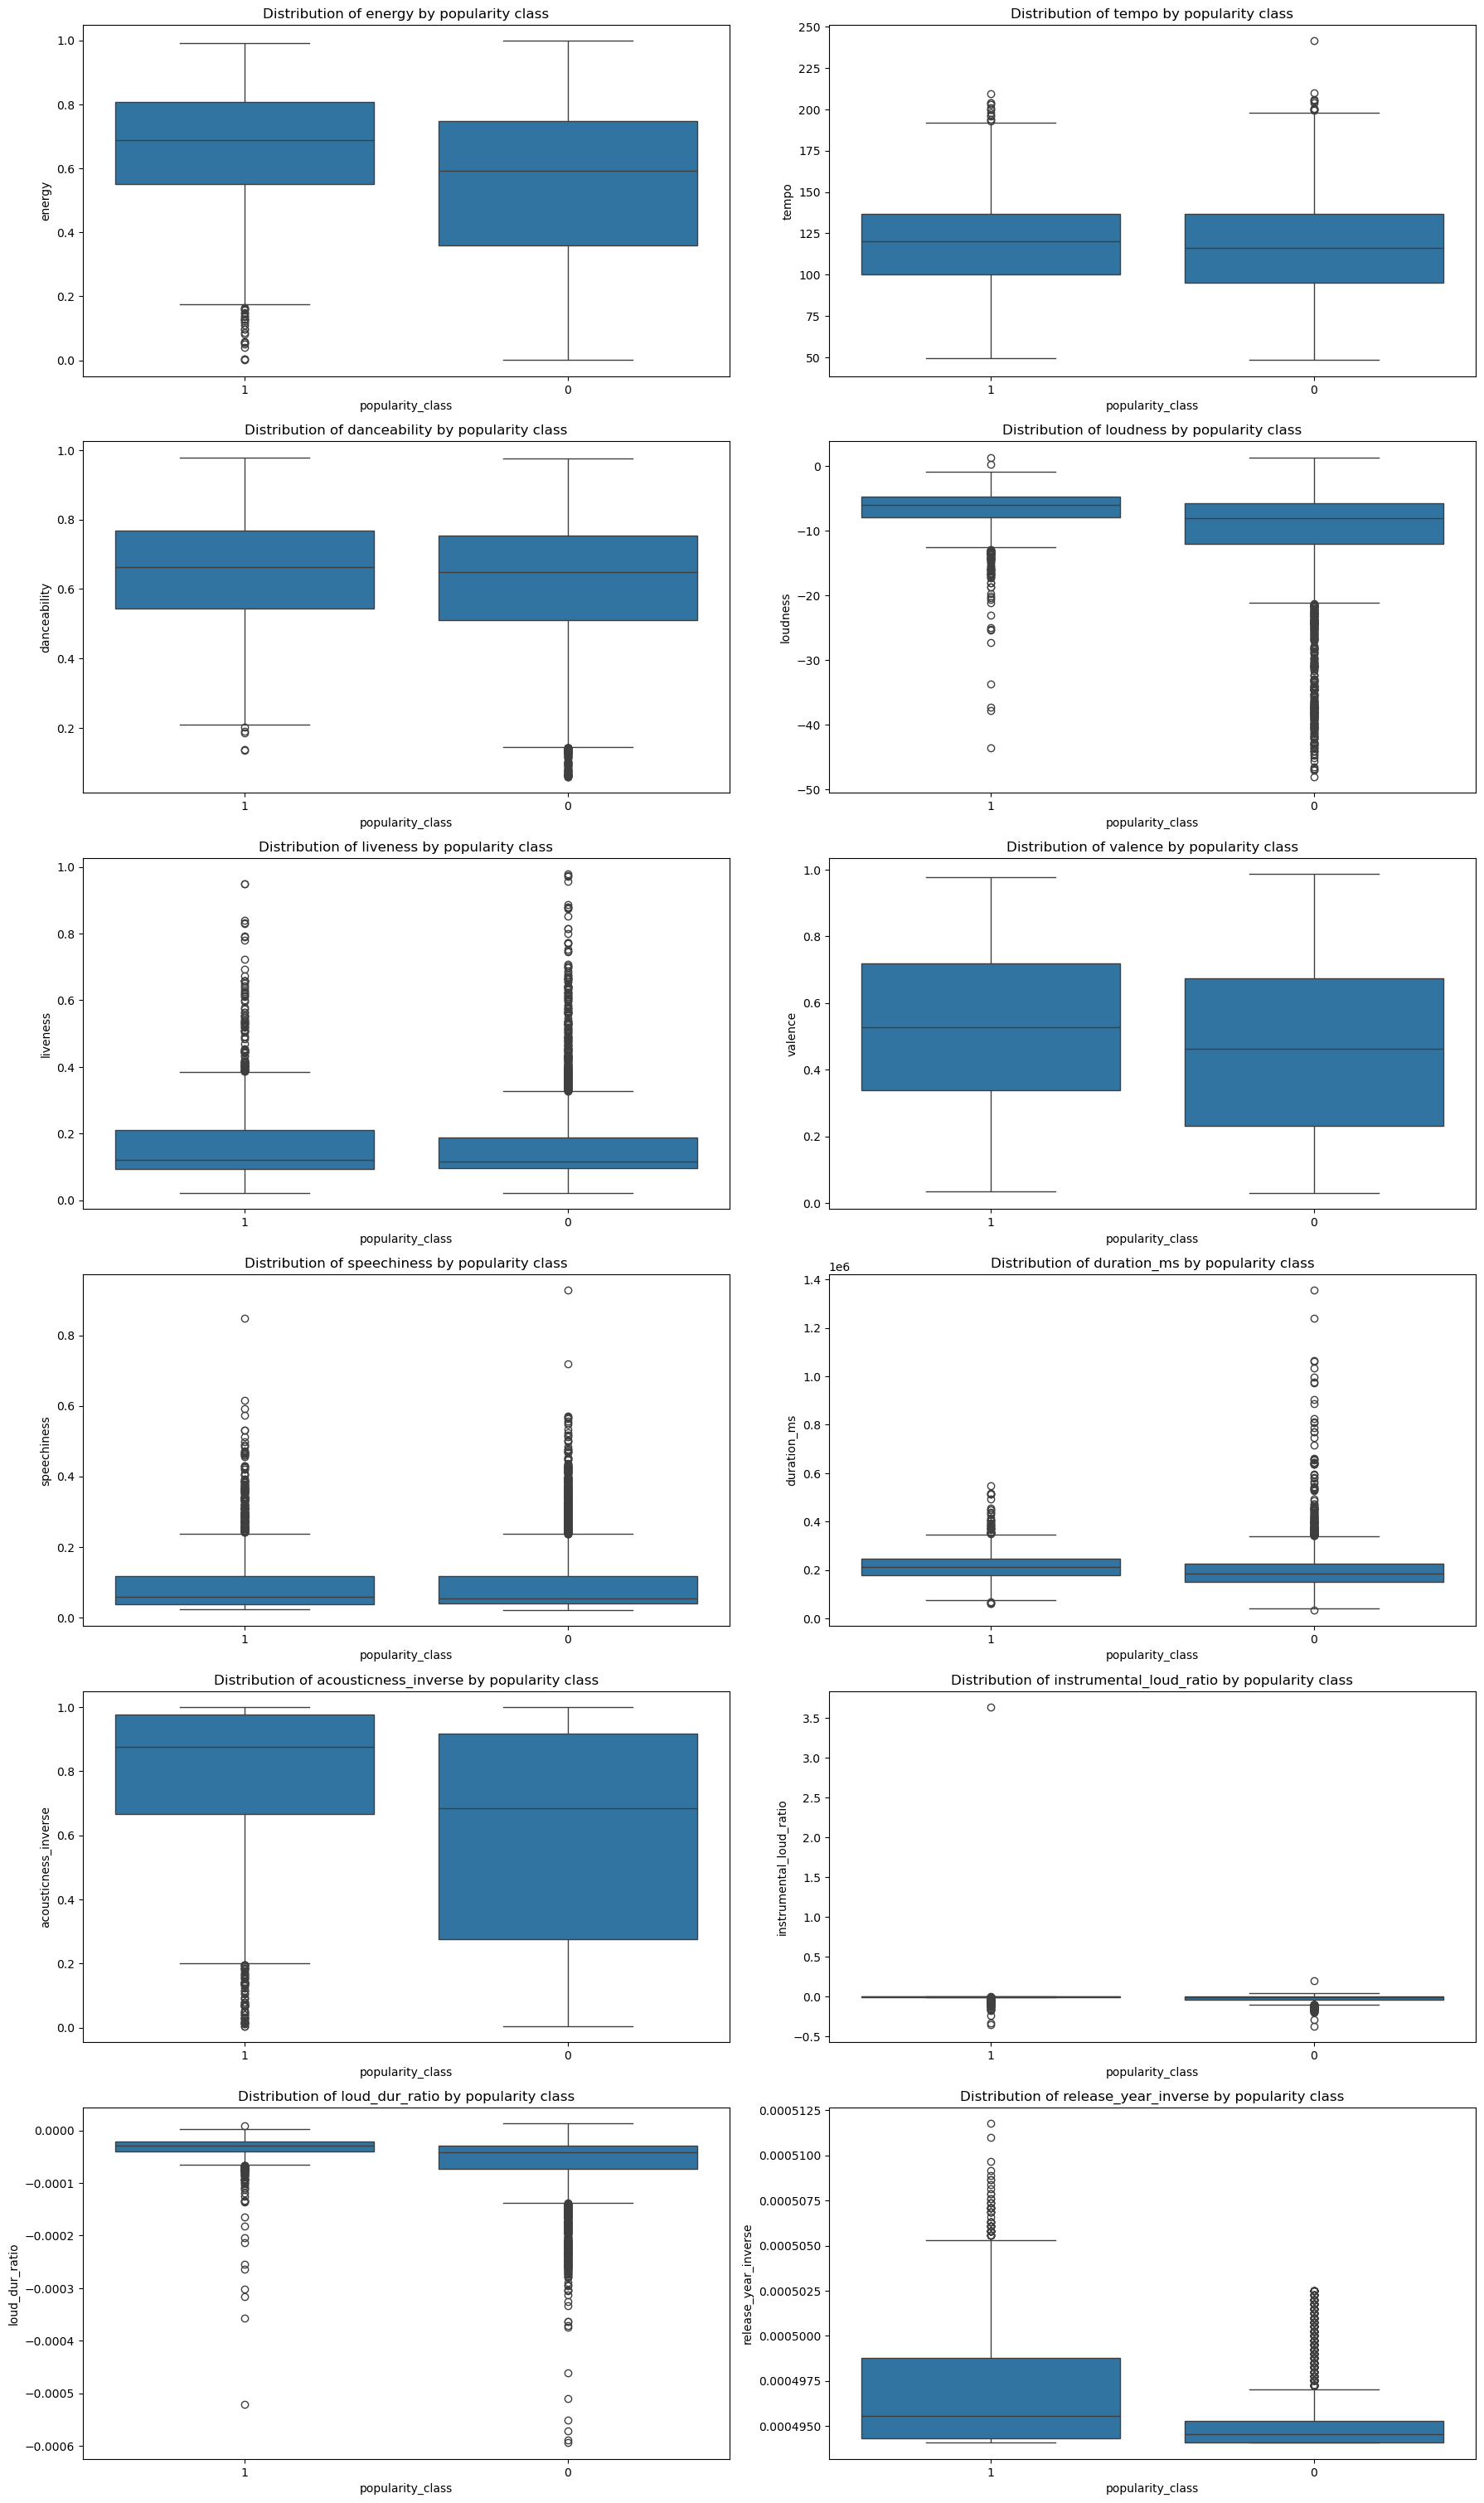

In [23]:
# Get list of numeric features (excluding the target if needed)
numeric_features = combined_df.select_dtypes(include=['float64', 'int64']).columns
numeric_features = numeric_features[numeric_features != 'popularity_class']

# Create a figure with subplots
plt.figure(figsize=(18, 5 * len(numeric_features)))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(len(numeric_features), 2, i)
    sns.boxplot(x='popularity_class', y=feature, data=combined_df)
    plt.title(f'Distribution of {feature} by popularity class')

plt.tight_layout()
plt.show()

### Handle Outliers

In [25]:
# Separate features and target
X = combined_df.drop(columns=['popularity_class'], axis=1)
y = combined_df['popularity_class']

# Remove outliers with Z-score < 2
mask = (np.abs(stats.zscore(X)) < 2).all(axis=1)

# Apply mask
X = X[mask]
y = y[mask]

### Boxplot For Outliers After Handling

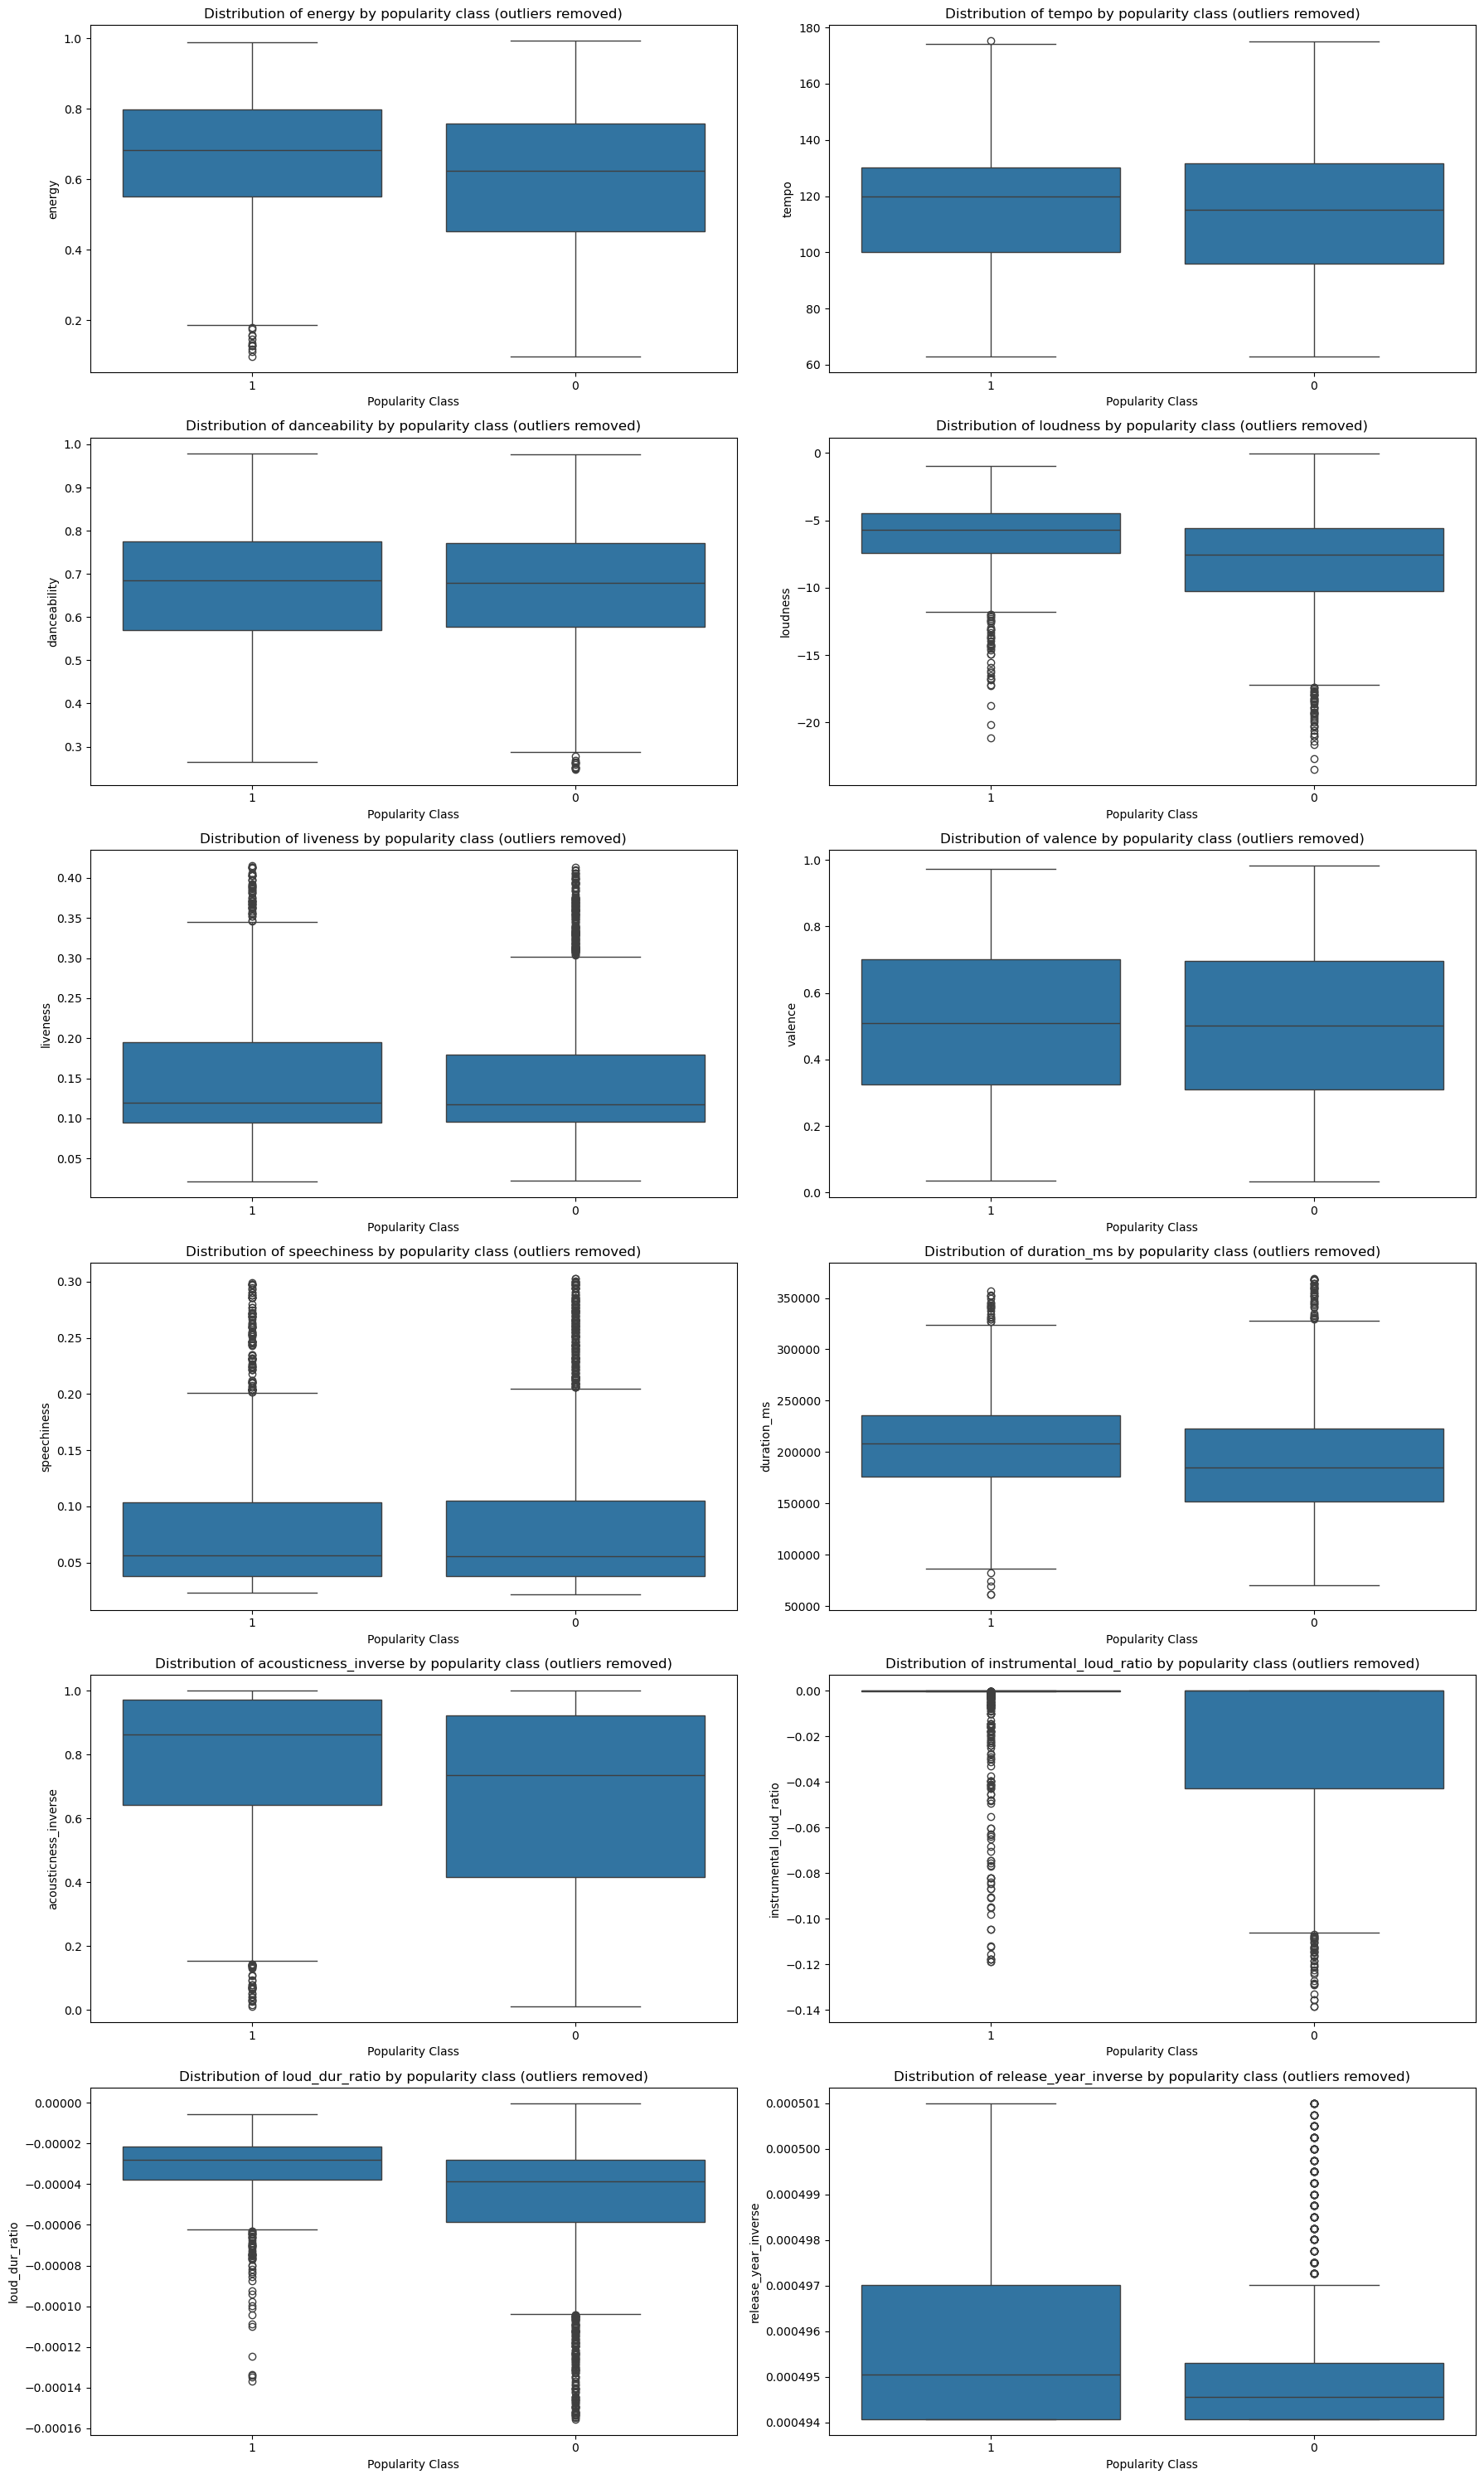

In [27]:
# Combine filtered X and y for plotting
filtered_df = X.copy()
filtered_df['popularity_class'] = y

# Get numeric features (excluding any remaining non-numeric columns if needed)
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns

# Create figure with subplots
n_cols = 2  # Number of columns in grid
n_rows = (len(numeric_features) + n_cols - 1) // n_cols  # Calculate needed rows

plt.figure(figsize=(18, 5 * n_rows))

# Create boxplot for each feature
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x='popularity_class', y=feature, data=filtered_df)
    plt.title(f'Distribution of {feature} by popularity class (outliers removed)')
    plt.xlabel('Popularity Class')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

### Split Data

In [29]:
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the distribution in both sets
print(f"Training set distribution:\n{y_train.value_counts()}")
print(f"\nTest set distribution:\n{y_test.value_counts()}")

Training set distribution:
popularity_class
0    1718
1     972
Name: count, dtype: int64

Test set distribution:
popularity_class
0    430
1    243
Name: count, dtype: int64


### Standardize Data and Filter-Out Anomalies

In [31]:
# Create the scaler
scaler = StandardScaler()
import joblib



# Scale training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the fitted scaler
joblib.dump(scaler, 'scaler.pkl')
iso = IsolationForest(contamination=0.01, random_state=42)
anomaly_labels = iso.fit_predict(X_train_scaled)

mask = anomaly_labels != -1
X_train_scaled = X_train_scaled[mask]
y_train = y_train[mask]

### Balance Data By Oversampling

In [33]:
# Create sampler
smote = SMOTE(random_state=42)

# Apply oversampling to data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
y_train_resampled = y_train_resampled.astype(int)
y_test = y_test.astype(int)

print(f"Training set distribution:\n{y_train_resampled.value_counts()}")

Training set distribution:
popularity_class
0    1696
1    1696
Name: count, dtype: int64


### Train Models on Dataset

In [35]:
# Dictionary of models to try
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

results = {}

# Loop through and train each model
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")

# Sort models by accuracy descending
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

print("\nModel Ranking by Accuracy:")
for i, (name, score) in enumerate(sorted_results, 1):
    print(f"{i}. {name}: {score:.4f}")

Logistic Regression Accuracy: 0.6582
Decision Tree Accuracy: 0.7979
Random Forest Accuracy: 0.8767
Gradient Boosting Accuracy: 0.8618
Support Vector Machine Accuracy: 0.7637
K-Nearest Neighbors Accuracy: 0.7296

Model Ranking by Accuracy:
1. Random Forest: 0.8767
2. Gradient Boosting: 0.8618
3. Decision Tree: 0.7979
4. Support Vector Machine: 0.7637
5. K-Nearest Neighbors: 0.7296
6. Logistic Regression: 0.6582


### Random Forest

In [37]:
model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
joblib.dump(model, 'popularity_predictor.pkl')


              precision    recall  f1-score   support

           0       0.90      0.91      0.90       430
           1       0.84      0.81      0.83       243

    accuracy                           0.88       673
   macro avg       0.87      0.86      0.87       673
weighted avg       0.88      0.88      0.88       673



['popularity_predictor.pkl']

### Check Feature Importance

In [39]:
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X_test.columns).sort_values(ascending=False)
print(feature_importance)

playlist_name              0.148078
playlist_subgenre          0.112861
playlist_genre             0.111113
instrumental_loud_ratio    0.076921
loud_dur_ratio             0.062638
release_year_inverse       0.056479
loudness                   0.053652
acousticness_inverse       0.047182
duration_ms                0.045992
valence                    0.044079
energy                     0.043533
speechiness                0.042048
tempo                      0.040894
danceability               0.040150
track_artist               0.039645
liveness                   0.034735
dtype: float64


In [40]:
joblib.dump(model, 'popularity_predictor.pkl')


['popularity_predictor.pkl']